In [3]:
# Lets do some ipr tests
import os
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from IPython.display import HTML
from IPython.display import display

from tqdm import tqdm

The Inverse Participation Ratio (IPR) of a normalized eigenvector provides a measure of its localization. For an eigenvector 
$v$ of a matrix, the IPR is calculated as the sum of the fourth powers of its components. This measure helps to understand how spread out or concentrated the eigenvector is across its dimensions.
$$\text{IPR}(v) = \sum_{i} |v_i|^4
$$

In [ ]:
'''Function to calculate the IPR of the data'''
def ipr_data(ne,ni):
    file = f'/home/baruva/scattering_data/del_circ/scattering_ensemble_del_circ_{ni}_{ne}.h5'
    tasks = 10000
    IPR = np.zeros((tasks,ne))
    try:
        with h5py.File(file, 'r') as f:
                for i in range(0,tasks):
                    data = f['S_ee'][f'matrix_{i}'][:]
                    _,v = np.linalg.eig(data)
                    # We have to randomly shuffle the columns of v to avoid the numpy ordering
                    v = v[:, np.random.permutation(v.shape[1])]
                    ipr = np.sum(np.abs(v)**4,axis=0)
                    IPR[i] = ipr
    except:
        # print(f'error with ne={ne} and ni={ni}')
        IPR = np.array([])

    return IPR

Circular Delaunay Networks

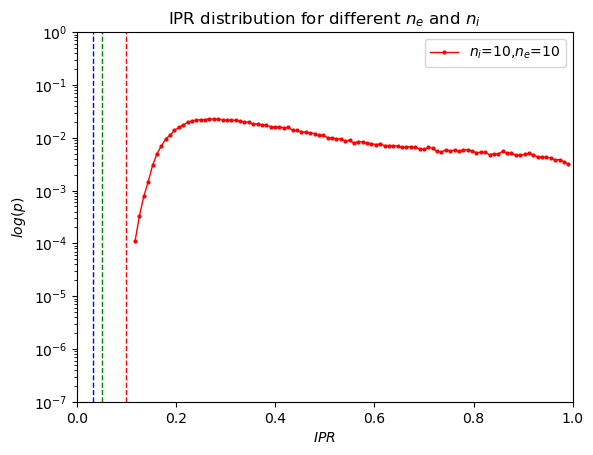

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
colors = ['r','g','b']
num_bins = 100
def update(i):
    ax.clear()
    r = range(10,451,10)
    for j,ne in enumerate([10,20,30]):
        data = ipr_data(ne,r[i])
        data_flat = data.flatten()
        bins,edges = np.histogram(data_flat, bins=num_bins)
        if len(data) != 0:
            ax.plot(edges[:-1], bins/bins.sum(),color = colors[j], marker='o',markersize=2,linestyle='-',lw=1, label=f'$n_i$={r[i]},$n_e$={ne}')
        plt.axvline(x=1/ne, color=colors[j], linestyle='--',lw=1)

    ax.set_xlabel('$IPR$')
    ax.set_ylabel('$log(p)$')
    ax.set_ylim(1e-7,1.0)
    ax.set_xlim(0,1)
    ax.set_yscale('log')
    ax.legend()
    ax.set_title(f'IPR distribution for different $n_e$ and $n_i$')
    return ax
r = range(10,451,10)
ani = FuncAnimation(fig, update, frames=len(r), repeat=False)
HTML(ani.to_jshtml())

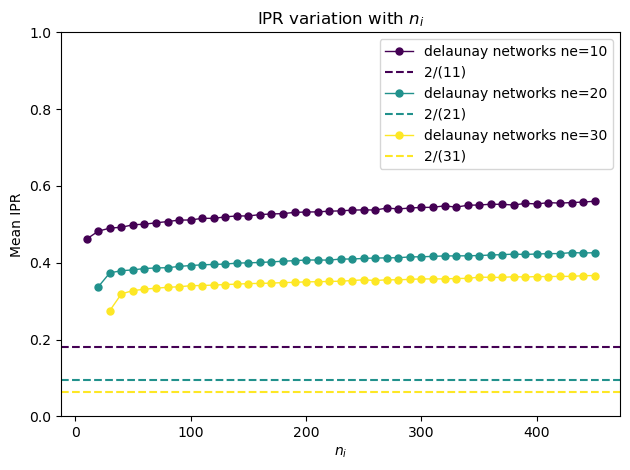

In [39]:
# Clear any existing plots first
plt.close('all')

# Now We will look at the mean IPR Statistics
def plot_avg(ne, c, ax):
    Mean_ipr = []
    Range = []
    step = 10
    r = range(ne, 451, step)
    
    for i in r:
        IPR = ipr_data(ne, i)
        if len(IPR) != 0:
            mean_ipr = np.mean(IPR)
            Mean_ipr.append(mean_ipr)
            Range.append(i)
            
    ax.plot(Range, Mean_ipr, color=c, marker="o", label=f'delaunay networks ne={ne}', markersize=5, lw=1)
    ax.axhline(y=2/(ne+1), color=c, linestyle='--', label=f'2/({ne+1})')
    
    return ax

# Create a single figure and axes
fig, ax = plt.subplots()

# Set common axis labels
ax.set_xlabel('$n_i$')
ax.set_ylabel('Mean IPR')
ax.set_ylim(0, 1)

# Create color map
colors = plt.cm.viridis(np.linspace(0, 1, 3))

# Plot each series on the same axes
plot_avg(10, colors[0], ax)
plot_avg(20, colors[1], ax)
plot_avg(30, colors[2], ax)

# Add title and legend to the combined figure
ax.set_title('IPR variation with $n_i$')
ax.legend()

# Display the figure
plt.tight_layout()
plt.show()

In [36]:
# distribution of reflection coefficients
def reflect_data_del_circ(ne,ni):
    file = f'/home/baruva/scattering_data/del_circ/scattering_ensemble_del_circ_{ni}_{ne}.h5'
    tasks = 10000
    reflect = np.zeros((tasks,ne))
    try:
        with h5py.File(file, 'r') as f:
                for i in range(0,tasks):
                    data = f['S_ee'][f'matrix_{i}'][:]
                    reflect[i] = np.abs(np.diagonal(data))
    except:
        # print(f'error with ne={ne} and ni={ni}')
        reflect = np.array([])

    return reflect

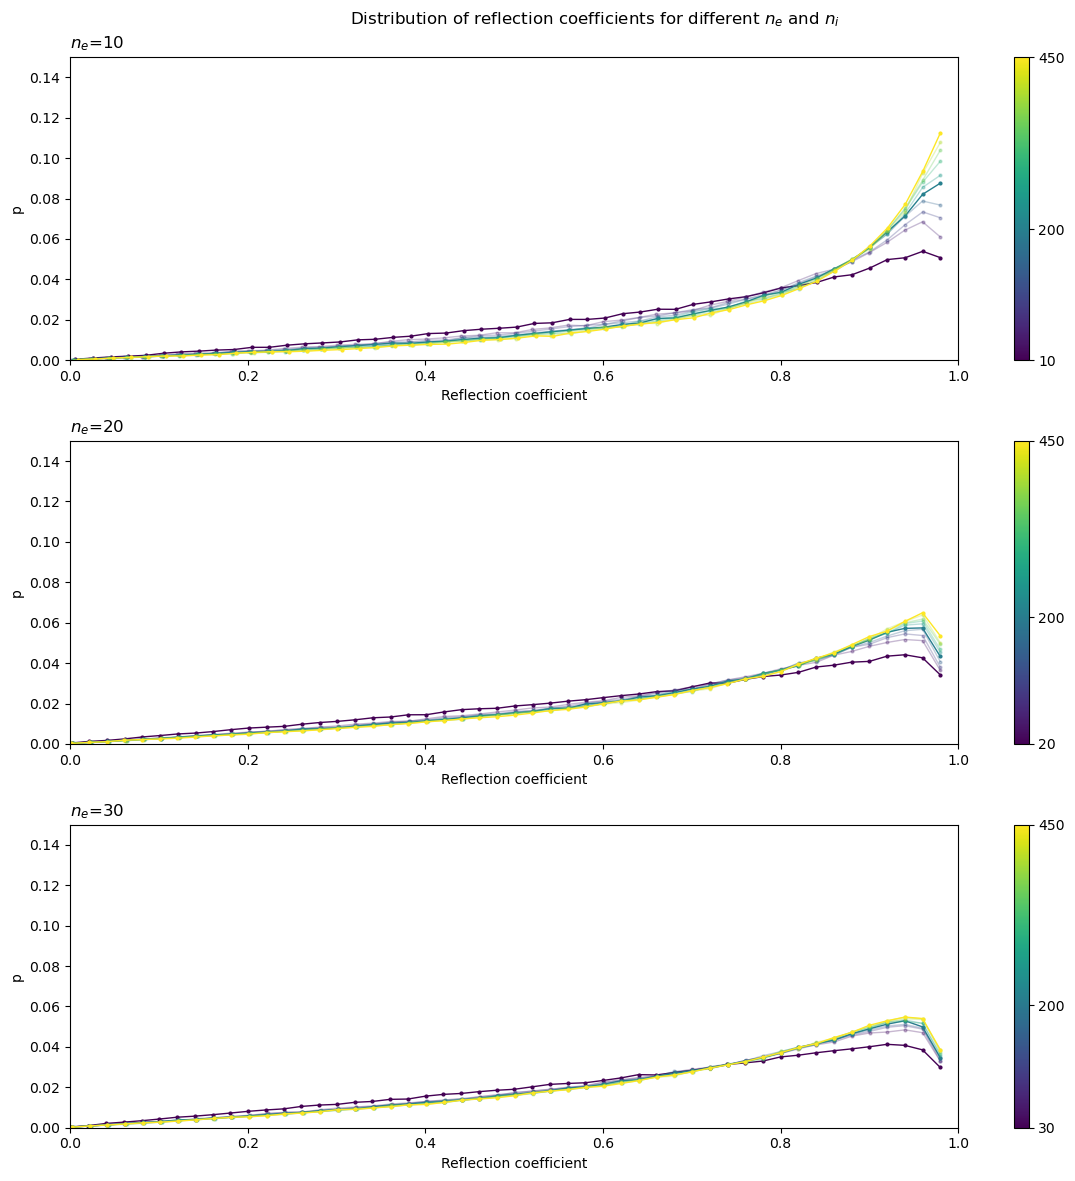

In [48]:
num_bins = 50
alpha = [1.0, 0.3, 0.3, 0.3, 1.0, 0.3, 0.3, 0.3, 0.3, 1.0]

# Create subplots
fig, ax = plt.subplots(3, 1, figsize=(12,12))
plt.suptitle('Distribution of reflection coefficients for different $n_e$ and $n_i$')

# Define n_e values and corresponding n_i sets
n_e_values = [10, 20, 30]
n_i_values = [
    [10, 50, 100, 150, 200, 250, 300, 350, 400, 450],
    [20, 50, 100, 150, 200, 250, 300, 350, 400, 450],
    [30, 50, 100, 150, 200, 250, 300, 350, 400, 450]
]

# Loop over subplots
for idx, (n_e, n_i_list) in enumerate(zip(n_e_values, n_i_values)):
    norm = plt.Normalize(min(n_i_list), max(n_i_list))  # Normalize color mapping

    for j, n_i in enumerate(n_i_list):
        bins, edges = np.histogram(reflect_data_del_circ(n_e, n_i).flatten(), bins=num_bins, density=True)
        color = plt.cm.viridis(norm(n_i))  # Assign color based on normalized n_i

        ax[idx].plot(edges[:-1], bins / bins.sum(), c=color, marker='o', markersize=2, 
                     linestyle='-', lw=1, alpha=alpha[j])

    # Formatting the subplot
    ax[idx].set_ylim(0, 0.15)
    ax[idx].set_xlim(0, 1)
    ax[idx].set_xlabel('Reflection coefficient')
    ax[idx].set_ylabel('p')
    ax[idx].set_title(f'$n_e$={n_e}', loc='left')

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax[idx], orientation='vertical')
    cbar.set_ticks([min(n_i_list), 200, max(n_i_list)])
    cbar.set_ticklabels([min(n_i_list), 200, max(n_i_list)])

plt.tight_layout()
plt.show()


Delaunay Slab Networks

In [5]:
'''Function to calculate the IPR of the data'''
def ipr_data_slab(ne,ni):
    file = f'/home/baruva/scattering_data/del_slab/scattering_ensemble_del_slab_{ni}_{ne}.h5'
    tasks = 10000
    IPR = np.zeros((tasks,2*ne))
    try:
        with h5py.File(file, 'r') as f:
                for i in range(0,tasks):
                    data = f['S_ee'][f'matrix_{i}'][:]
                    _,v = np.linalg.eig(data)
                    np.random.seed(i+5521586)
                    # We have to randomly shuffle the columns of v to avoid the numpy ordering
                    v = v[:, np.random.permutation(v.shape[1])]
                    ipr = np.sum(np.abs(v)**4,axis=0)
                    IPR[i] = ipr
    except:
        # print(f'error with ne={ne} and ni={ni}')
        IPR = np.array([])

    return IPR

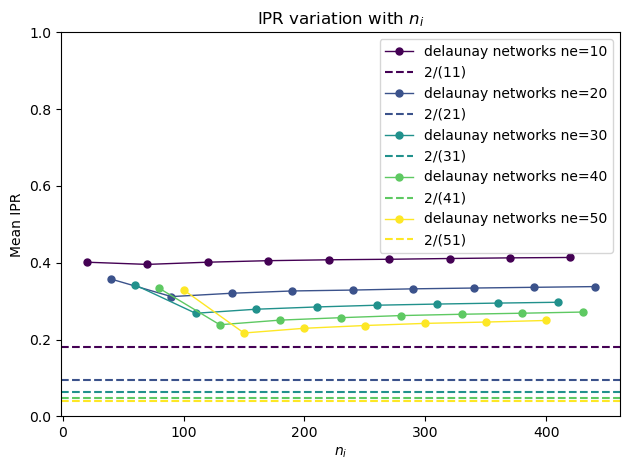

In [ ]:
# Clear any existing plots first
plt.close('all')

# Now We will look at the mean IPR Statistics
def plot_avg(ne, c, ax):
    Mean_ipr = []
    Range = []
    step = 50
    r = range(2*ne, 451, step)
    
    for i in r:
        IPR = ipr_data_slab(ne, i)
        if len(IPR) != 0:
            mean_ipr = np.mean(IPR)
            Mean_ipr.append(mean_ipr)
            Range.append(i)
            
    ax.plot(Range, Mean_ipr, color=c, marker="o", label=f'delaunay networks ne={ne}', markersize=5, lw=1)
    ax.axhline(y=2/(ne+1), color=c, linestyle='--', label=f'2/({ne+1})')
    
    return ax

# Create a single figure and axes
fig, ax = plt.subplots()

# Set common axis labels
ax.set_xlabel('$n_i$')
ax.set_ylabel('Mean IPR')
ax.set_ylim(0, 1)

# Create color map
colors = plt.cm.viridis(np.linspace(0, 1, 5))

# Plot each series on the same axes
plot_avg(10, colors[0], ax)
plot_avg(20, colors[1], ax)
plot_avg(30, colors[2], ax)
plot_avg(40, colors[3], ax)
plot_avg(50, colors[4], ax)

# Add title and legend to the combined figure
ax.set_title('IPR variation with $n_i$')
ax.legend(loc = (1))

# Display the figure
plt.tight_layout()
plt.show()

In [4]:
# distribution of reflection coefficients
def reflect_data_del_slab(ne,ni):
    file = f'/home/baruva/scattering_data/del_slab/scattering_ensemble_del_slab_{ni}_{ne}.h5'
    tasks = 10000
    reflect = np.zeros((tasks,2*ne))
    try:
        with h5py.File(file, 'r') as f:
                for i in range(0,tasks):
                    data = f['S_ee'][f'matrix_{i}'][:]
                    reflect[i] = np.abs(np.diagonal(data))
    except Exception as e:
        print(e)
        reflect = np.array([])

    return reflect

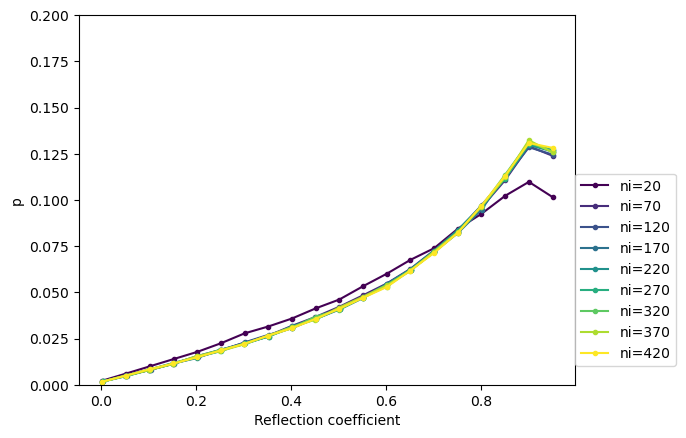

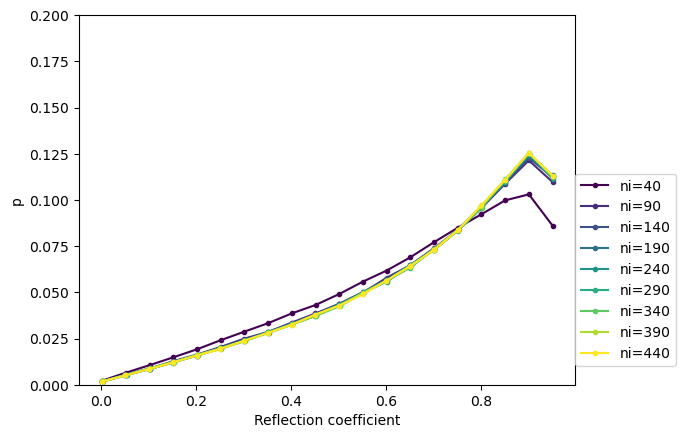

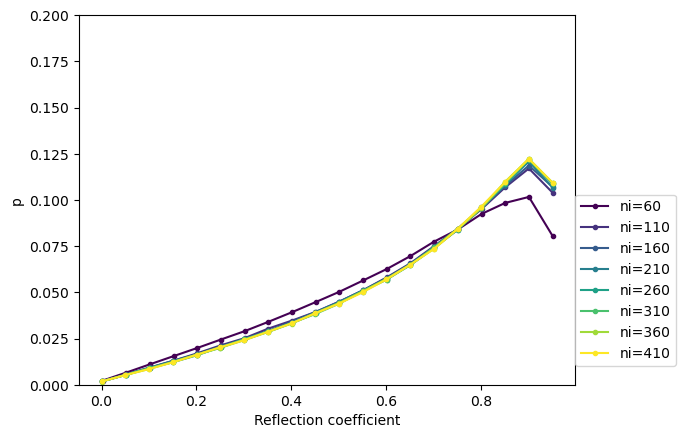

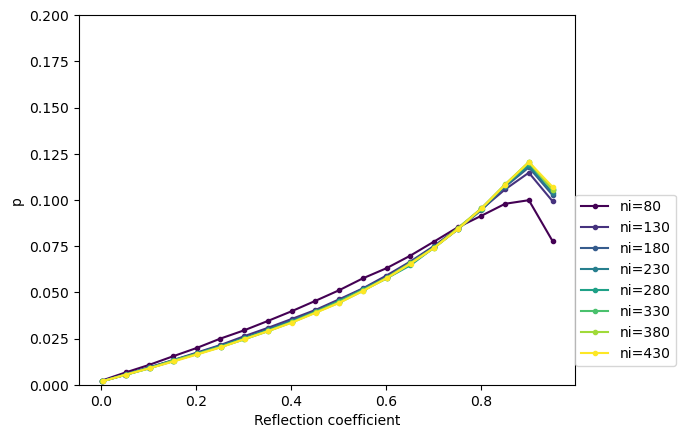

[Errno 2] Unable to synchronously open file (unable to open file: name = '/home/baruva/scattering_data/del_slab/scattering_ensemble_del_slab_450_50.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


/tmp/ipykernel_2329433/4059133338.py:58: RuntimeWarning: invalid value encountered in divide
  plt.plot(edges[:-1], bins/bins.sum(),label=f'ni={ni}',marker='.',color=colors[j])


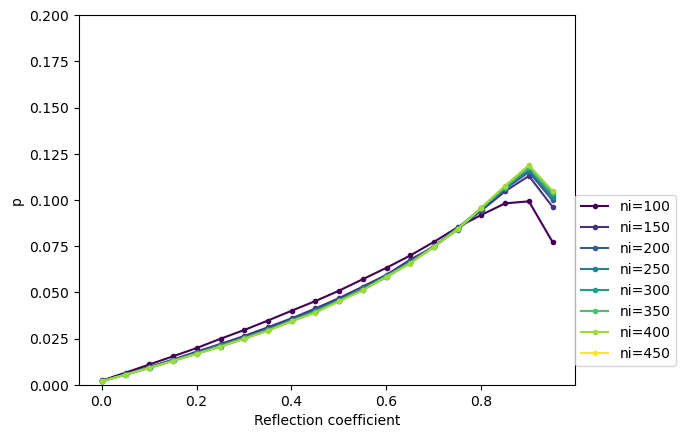

In [11]:
ne = 10
range_ni = range(2*ne,451,50)
colors = plt.cm.viridis(np.linspace(0,1,len(range_ni)))
for j,ni in enumerate(range_ni):
    a = reflect_data_del_slab(ne, ni)
    bins,edges = np.histogram(a.flatten(), bins=20)
    plt.plot(edges[:-1], bins/bins.sum(),label=f'ni={ni}',marker='.',color=colors[j])
plt.legend(loc=(1.0,0.05))
plt.ylim(0,0.2)
plt.xlabel('Reflection coefficient')
plt.ylabel('p')
plt.show()

ne = 20
range_ni = range(2*ne,451,50)
colors = plt.cm.viridis(np.linspace(0,1,len(range_ni)))
for j,ni in enumerate(range_ni):
    a = reflect_data_del_slab(ne, ni)
    bins,edges = np.histogram(a.flatten(), bins=20)
    plt.plot(edges[:-1], bins/bins.sum(),label=f'ni={ni}',marker='.',color=colors[j])
plt.legend(loc=(1.0,0.05))
plt.ylim(0,0.2)
plt.xlabel('Reflection coefficient')
plt.ylabel('p')
plt.show()

ne=30
range_ni = range(2*ne,451,50)
colors = plt.cm.viridis(np.linspace(0,1,len(range_ni)))
for j,ni in enumerate(range_ni):
    a = reflect_data_del_slab(ne, ni)
    bins,edges = np.histogram(a.flatten(), bins=20)
    plt.plot(edges[:-1], bins/bins.sum(),label=f'ni={ni}',marker='.',color=colors[j])
plt.legend(loc=(1.0,0.05))
plt.ylim(0,0.2)
plt.xlabel('Reflection coefficient')
plt.ylabel('p')
plt.show()

ne = 40
range_ni = range(2*ne,451,50)
colors = plt.cm.viridis(np.linspace(0,1,len(range_ni)))
for j,ni in enumerate(range_ni):
    a = reflect_data_del_slab(ne, ni)
    bins,edges = np.histogram(a.flatten(), bins=20)
    plt.plot(edges[:-1], bins/bins.sum(),label=f'ni={ni}',marker='.',color=colors[j])
plt.legend(loc=(1.0,0.05))
plt.ylim(0,0.2)
plt.xlabel('Reflection coefficient')
plt.ylabel('p')
plt.show()

ne = 50
range_ni = range(2*ne,451,50)
colors = plt.cm.viridis(np.linspace(0,1,len(range_ni)))
for j,ni in enumerate(range_ni):
    a = reflect_data_del_slab(ne, ni)
    bins,edges = np.histogram(a.flatten(), bins=20)
    plt.plot(edges[:-1], bins/bins.sum(),label=f'ni={ni}',marker='.',color=colors[j])
plt.legend(loc=(1.0,0.05))
plt.ylim(0,0.2)
plt.xlabel('Reflection coefficient')
plt.ylabel('p')
plt.show()

Buffon Circular Networks

In [12]:
'''Function to calculate the IPR of the data'''
def ipr_data_circ(ne):
    file = f'/home/baruva/scattering_data/buf_circ/scattering_ensemble_buf_circ_{ne}1.h5'
    tasks = 10000
    IPR = np.zeros((tasks,2*ne))
    try:
        with h5py.File(file, 'r') as f:
                for i in range(0,tasks):
                    data = f['S_ee'][f'matrix_{i}'][:]
                    _,v = np.linalg.eig(data)
                    np.random.seed(i+5521586)
                    # We have to randomly shuffle the columns of v to avoid the numpy ordering
                    v = v[:, np.random.permutation(v.shape[1])]
                    ipr = np.sum(np.abs(v)**4,axis=0)
                    IPR[i] = ipr
    except:
        # print(f'error with ne={ne} and ni={ni}')
        IPR = np.array([])

    return IPR

In [13]:
ipr_data_circ(10)

array([], dtype=float64)